In [8]:
import scanpy as sc
import numpy as np
import scCRAFT
from scCRAFT.model import *
import scvi
import scib 
import harmonypy as hm
import pandas as pd
import scanorama
import time
import bbknn
import scDML
from scDML import scDMLModel
from scDML.utils import print_dataset_information
import imap
from scib.utils import *

In [4]:
adata = sc.read_h5ad("/path/Pancrease_raw.h5ad")
adata.raw = adata
adata.layers["counts"] = adata.X.copy()
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=5)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key='tech')
adata = adata[:, adata.var['highly_variable']]

150


Overall Progress:   0%|          | 0/150 [00:00<?, ?it/s]

Training completed in 196.20 seconds


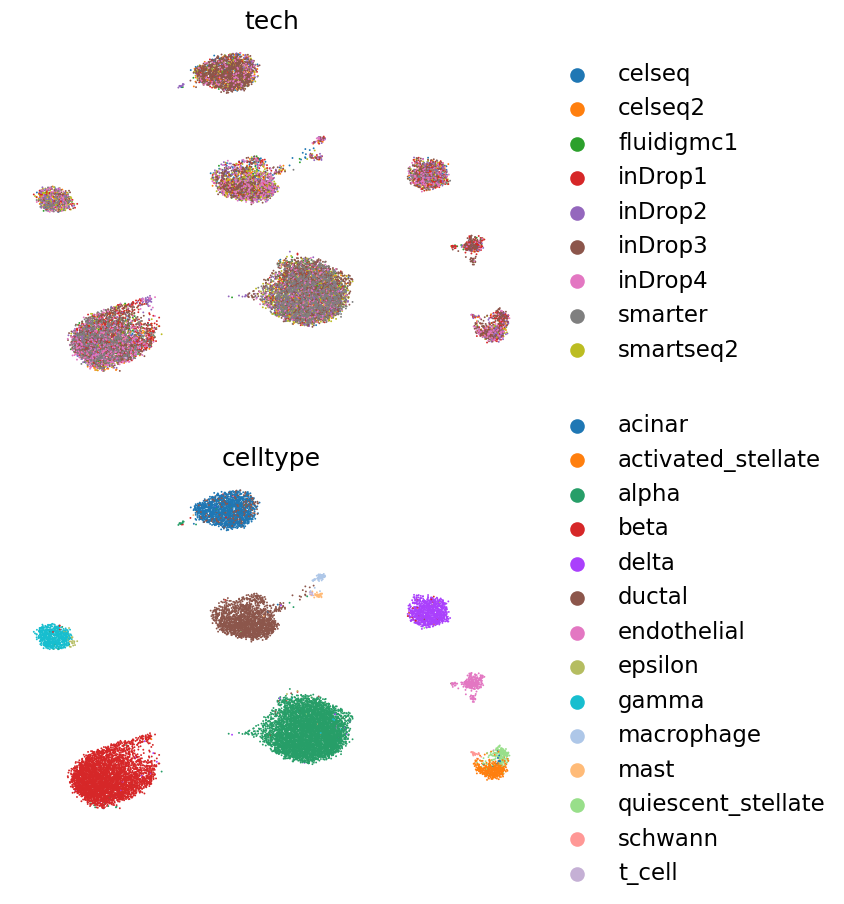

In [5]:
multi_resolution_cluster(adata, resolution1 = 0.5, method = 'Leiden')
VAE = train_integration_model(adata, batch_key = 'tech', z_dim=256)
obtain_embeddings(adata, VAE)
sc.pp.neighbors(adata, use_rep="X_scCRAFT")
sc.tl.umap(adata, min_dist=0.5)
sc.pl.umap(adata, color=["tech", "celltype"], frameon=False, ncols=1)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|██████████| 400/400 [07:20<00:00,  1.03s/it, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.22e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [07:20<00:00,  1.10s/it, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.22e+3]


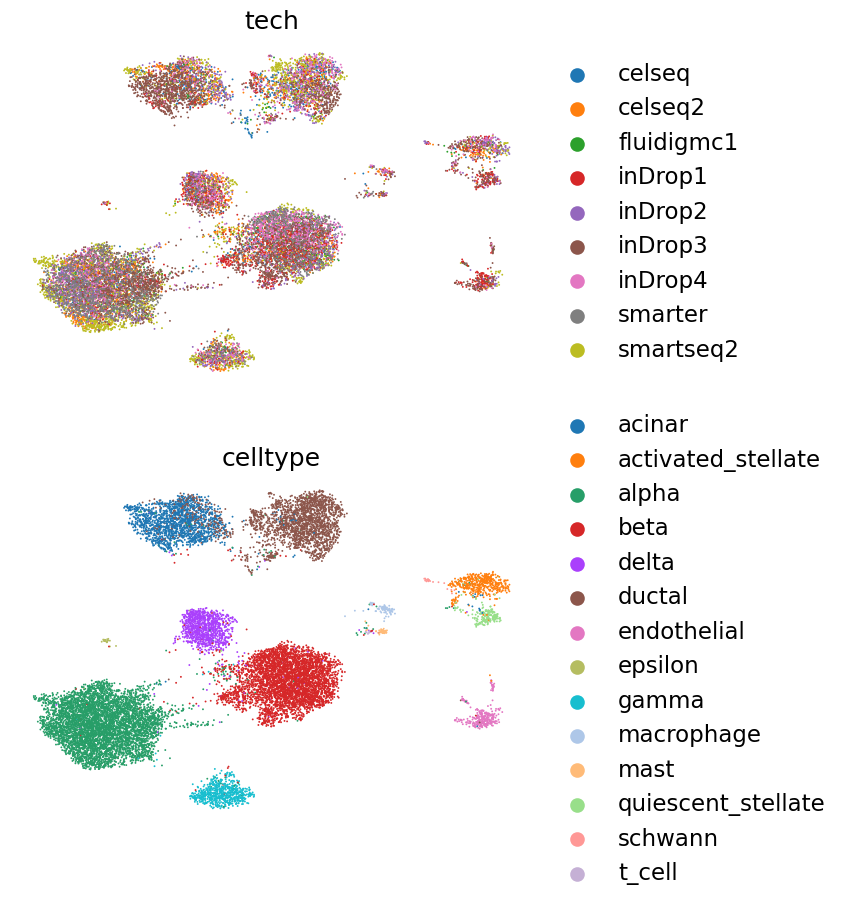

In [4]:
# scVI
adata = adata.copy()
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="tech") 
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=50, gene_likelihood="nb")
vae.train()
adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.5)
sc.pl.umap(adata, color=["tech", "celltype"], frameon=False, ncols=1)

2024-04-27 10:26:53,121 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-04-27 10:26:57,248 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-04-27 10:26:57,290 - harmonypy - INFO - Iteration 1 of 10
2024-04-27 10:26:59,867 - harmonypy - INFO - Iteration 2 of 10
2024-04-27 10:27:02,312 - harmonypy - INFO - Iteration 3 of 10
2024-04-27 10:27:04,722 - harmonypy - INFO - Iteration 4 of 10
2024-04-27 10:27:07,168 - harmonypy - INFO - Iteration 5 of 10
2024-04-27 10:27:09,382 - harmonypy - INFO - Iteration 6 of 10
2024-04-27 10:27:11,865 - harmonypy - INFO - Iteration 7 of 10
2024-04-27 10:27:13,578 - harmonypy - INFO - Iteration 8 of 10
2024-04-27 10:27:14,468 - harmonypy - INFO - Converged after 8 iterations


Training completed in 21.36 seconds


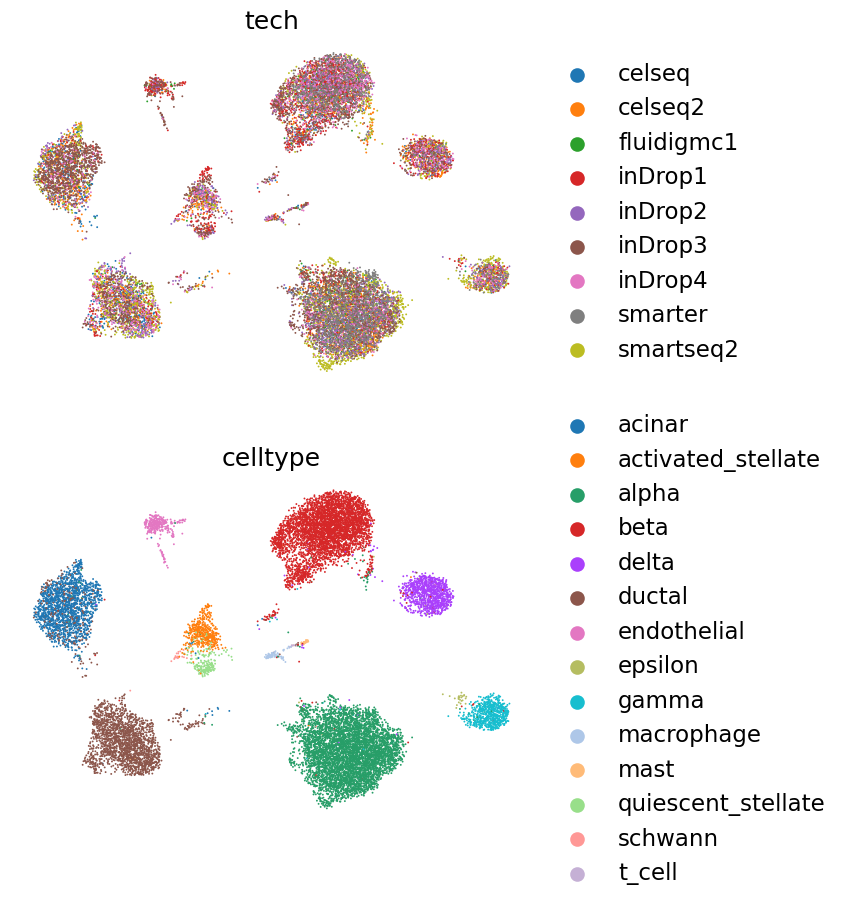

In [5]:
# Harmony
sc.tl.pca(adata, n_comps=50)
data_mat = adata.obsm['X_pca']
meta_data = adata.obs

# Specify the variables to use (as in your original code)
vars_use = ['tech']

# Run Harmony
start_time = time.time() 
ho = hm.run_harmony(data_mat, meta_data, vars_use)
end_time = time.time()
training_time = end_time - start_time
print(f"Training completed in {training_time:.2f} seconds")

# Convert the adjusted PCs to a DataFrame
res = pd.DataFrame(ho.Z_corr)
res.columns = ['X{}'.format(i + 1) for i in range(res.shape[1])]

# If you want to store the adjusted PCs back into the AnnData object
adata.obsm['X_harmony'] = res.values.T
sc.pp.neighbors(adata, use_rep="X_harmony")
sc.tl.umap(adata, min_dist=0.5)
sc.pl.umap(adata, color=["tech", "celltype"], frameon=False, ncols=1)

Found 2000 genes among all datasets
[[0.         0.67877462 0.06112853 0.2061753  0.14641434 0.01792829
  0.05278884 0.05630027 0.21613546]
 [0.         0.         0.06426332 0.05575632 0.0162413  0.00393873
  0.00690714 0.0616622  0.59124726]
 [0.         0.         0.         0.02194357 0.0031348  0.01410658
  0.         0.68965517 0.0846395 ]
 [0.         0.         0.         0.         0.54414042 0.67372225
  0.35149655 0.00929272 0.02589808]
 [0.         0.         0.         0.         0.         0.33468677
  0.71925754 0.00268097 0.06264501]
 [0.         0.         0.         0.         0.         0.
  0.4627782  0.01081831 0.01692094]
 [0.         0.         0.         0.         0.         0.
  0.         0.0475825  0.17958557]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.58378016]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]]
Processing datasets (4, 6)
Processing datasets (2, 7)
Proce

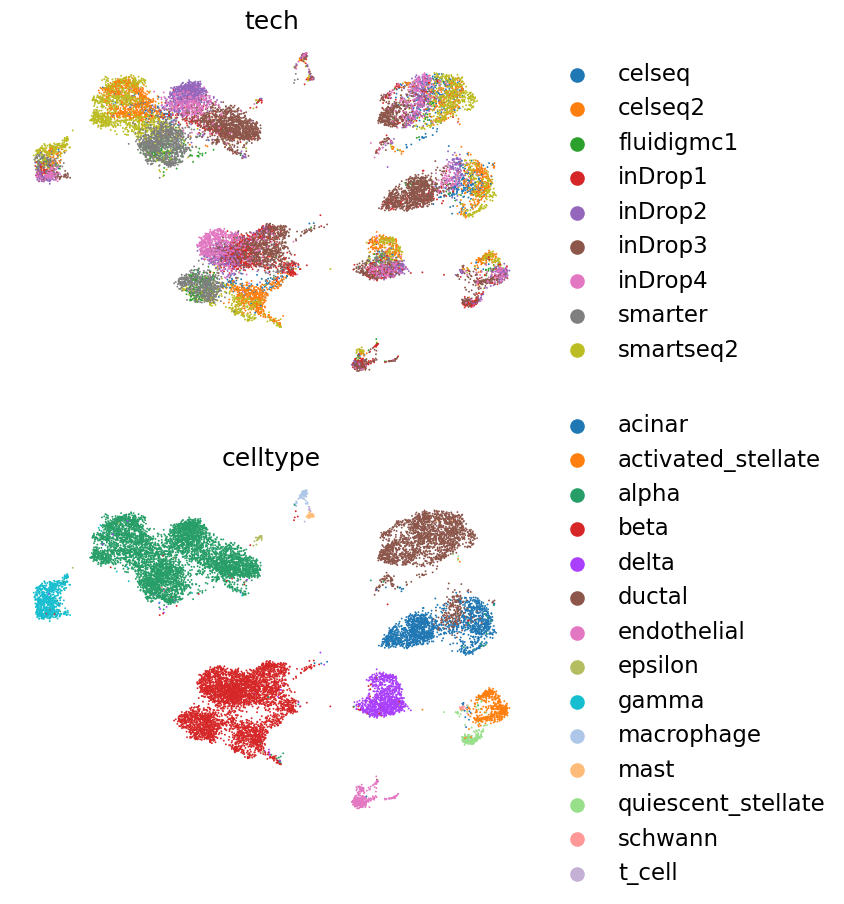

In [9]:
#Scanorama
# Save original order of cells
original_order = adata.obs_names.copy()

# Start timer
start_time = time.time()

# Your existing Scanorama correction process
split, categories = split_batches(adata.copy(), 'tech', return_categories=True)
corrected = scanorama.correct_scanpy(split, return_dimred=True)
corrected = anndata.AnnData.concatenate(
    *corrected, batch_key='tech', batch_categories=categories, index_unique=None
)

# Reorder corrected data to match original order
corrected = corrected[original_order]

# End timer
end_time = time.time()
training_time = end_time - start_time
print(f"Training completed in {training_time:.2f} seconds")

# Replace adata with corrected data
adatas = corrected.copy()

adata.obsm['X_scanorama'] = adatas.obsm['X_scanorama']

# Proceed with your analysis (neighbors, UMAP, plotting)
sc.pp.neighbors(adata, n_pcs=50, use_rep="X_scanorama")
sc.tl.umap(adata)
sc.pl.umap(adata, color=["tech", "celltype"], frameon=False, ncols=1)

Training completed in 2.68 seconds


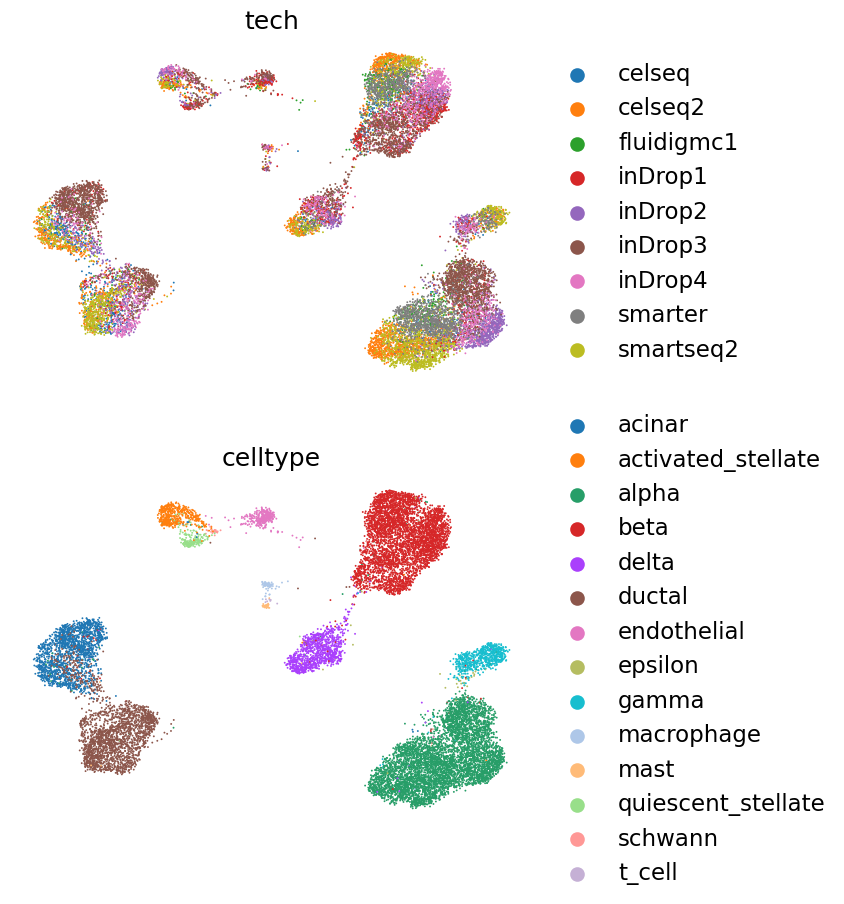

In [6]:
start_time = time.time() 
bbknn.bbknn(adata, batch_key='tech')
end_time = time.time()
training_time = end_time - start_time
print(f"Training completed in {training_time:.2f} seconds")
sc.tl.umap(adata, min_dist=0.5)
sc.pl.umap(adata, color=["tech", "celltype"], frameon=False, ncols=1)
adata.obsm['X_bbknn'] = adata.obsm['X_umap']

HI
Step 1: Calibrating Celltype...
[Epoch 1/50] [Reconstruction loss: 0.220517] [Cotent loss: 0.003228]
[Epoch 2/50] [Reconstruction loss: 0.218132] [Cotent loss: 0.001423]
[Epoch 3/50] [Reconstruction loss: 0.218818] [Cotent loss: 0.000817]
[Epoch 4/50] [Reconstruction loss: 0.217549] [Cotent loss: 0.000787]
[Epoch 5/50] [Reconstruction loss: 0.211796] [Cotent loss: 0.001403]
[Epoch 6/50] [Reconstruction loss: 0.196626] [Cotent loss: 0.000886]
[Epoch 7/50] [Reconstruction loss: 0.183911] [Cotent loss: 0.000650]
[Epoch 8/50] [Reconstruction loss: 0.171805] [Cotent loss: 0.000565]
[Epoch 9/50] [Reconstruction loss: 0.163507] [Cotent loss: 0.000461]
[Epoch 10/50] [Reconstruction loss: 0.160722] [Cotent loss: 0.000422]
[Epoch 11/50] [Reconstruction loss: 0.157622] [Cotent loss: 0.000752]
[Epoch 12/50] [Reconstruction loss: 0.152366] [Cotent loss: 0.000374]
[Epoch 13/50] [Reconstruction loss: 0.148868] [Cotent loss: 0.000315]
[Epoch 14/50] [Reconstruction loss: 0.146984] [Cotent loss: 0.00

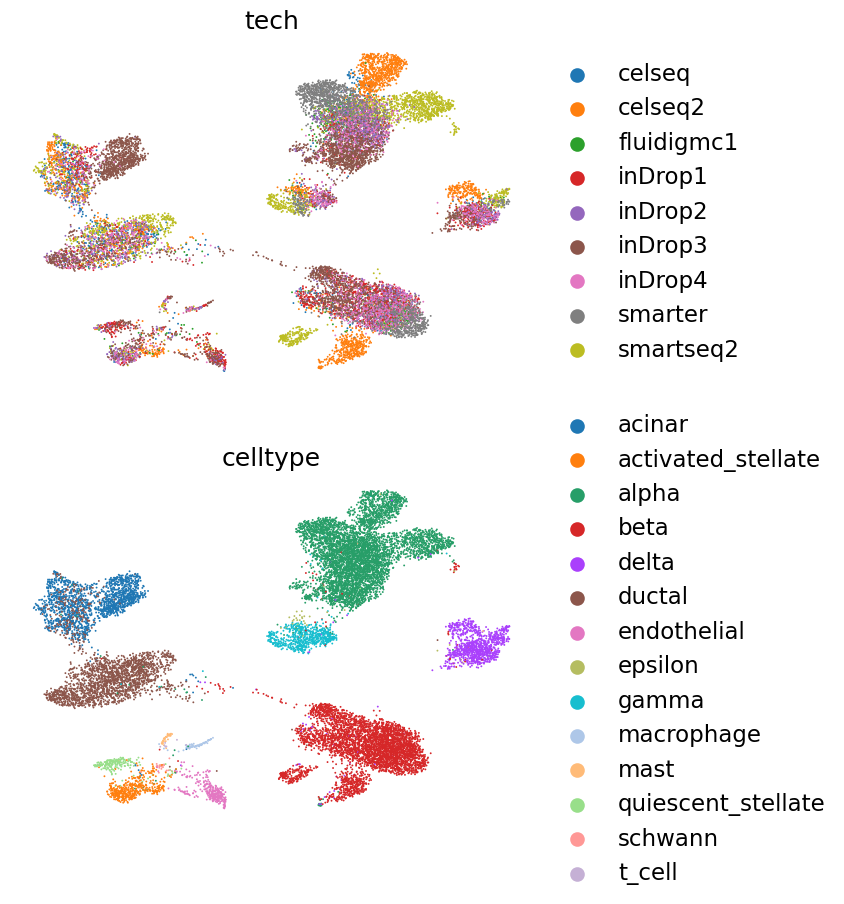

In [7]:
#iMAP

if type(adata.X) != type(np.array([])):
    adata.X = adata.X.toarray()
start_time = time.time() 
### Stage I
print('HI')
EC, ec_data = imap.stage1.iMAP_fast(adata, key='tech', n_epochs=50)
### Stage II
output_results = imap.stage2.integrate_data(adata, ec_data, key='tech', n_epochs=40)
output_results.shape
end_time = time.time()
print('total time talken', end_time-start_time)
adata_int = adata.copy()
adata_int.X = output_results

sc.tl.pca(adata_int, n_comps=50)
sc.pp.neighbors(adata_int, use_rep="X_pca")
sc.tl.umap(adata_int, min_dist=0.5)
sc.pl.umap(adata_int, color=["tech", "celltype"], frameon=False, ncols=1)
adata.obsm['imap'] = adata_int.obsm['X_pca']

2024-04-27 10:36:33,486 - root - INFO - Create log file....
2024-04-27 10:36:33,486 - root - INFO - Create scDMLModel Object Done....
2024-04-27 10:36:33,861 - root - INFO - Running preprocess() function...
2024-04-27 10:36:33,862 - root - INFO - mode=unsupervised
2024-04-27 10:36:33,862 - root - INFO - clustering method=louvain
2024-04-27 10:36:33,862 - root - INFO - resolution=3.0
2024-04-27 10:36:33,862 - root - INFO - BATCH_key=tech
2024-04-27 10:36:33,862 - root - INFO - Normalize counts per cell(sum=10000.0)
2024-04-27 10:36:33,888 - root - INFO - Log1p data


2024-04-27 10:36:33,907 - root - INFO - Select HVG(n_top_genes=1000)
2024-04-27 10:36:34,479 - root - INFO - Scale batch(scale_value=10.0)
2024-04-27 10:36:35,642 - root - INFO - Calculate PCA(n_comps=100)


         Falling back to preprocessing with `sc.pp.pca` and default params.


2024-04-27 10:36:38,723 - root - INFO - Apply louvain clustring(resolution=3.0) initization
2024-04-27 10:36:38,725 - root - INFO - Number of Cluster =36
2024-04-27 10:36:38,725 - root - INFO - clusters=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]
2024-04-27 10:36:38,726 - root - INFO - Preprocess Dataset Done...
2024-04-27 10:36:38,727 - root - INFO - mode=unsupervised
2024-04-27 10:36:38,767 - root - INFO - K_in=5,K_bw=10
2024-04-27 10:36:38,767 - root - INFO - Calculate similarity of cluster with KNN and MNN
2024-04-27 10:36:38,767 - root - INFO - appoximate calculate KNN Pair intra batch...
2024-04-27 10:36:38,773 - root - INFO - Calculate KNN pair intra batch...........
2024-04-27 10:36:38,773 - root - INFO - K=5
2024-04-27 10:36:38,773 - root - INFO - metric=cosine
2024-04-27 10:36:38,773 - root - INFO - Processing datasets: (0, 0) = ('celseq', 'celseq')
2024-04-27 10:36:38,797 - root - INFO

time taken to run : 170.9524426460266


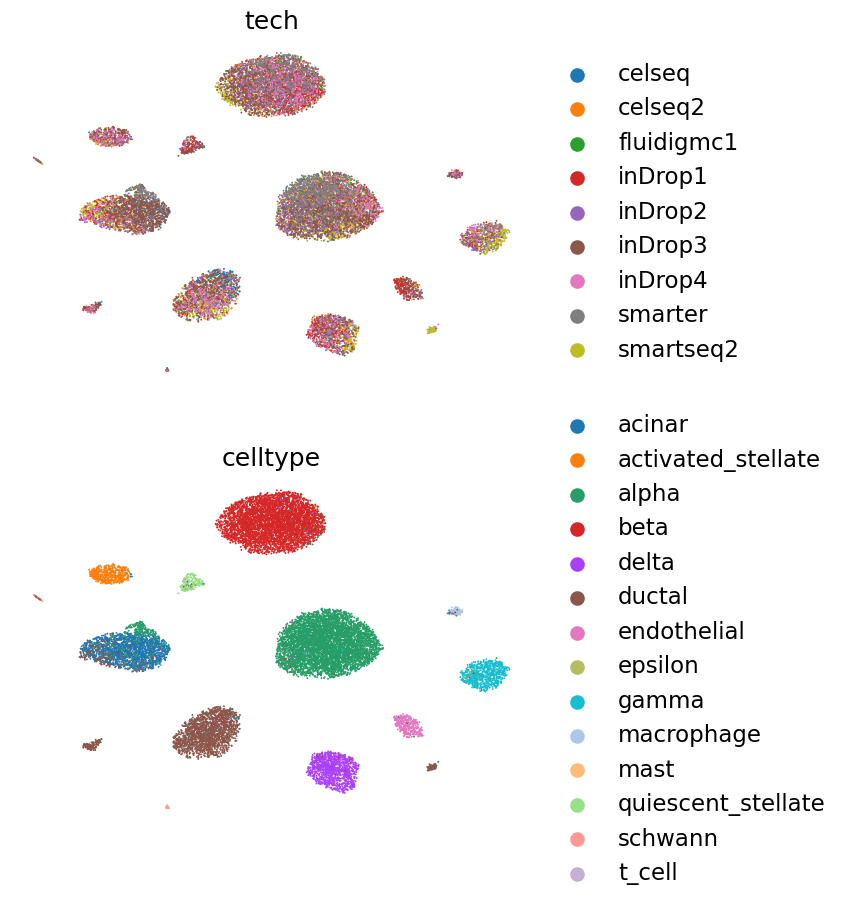

In [8]:
#scDML
adata.obs['original_order_id'] = range(adata.shape[0])
start_time = time.time()
ncluster = len(adata.obs['celltype'].unique())
scdml=scDMLModel()
adata_int = adata.copy()
adata_int=scdml.preprocess(adata_int, cluster_method="louvain",resolution=3.0,batch_key = 'tech')
scdml.integrate(adata_int,batch_key='tech',ncluster_list=[ncluster],
               expect_num_cluster=ncluster,merge_rule="rule2", out_dim=50)
end_time = time.time()
print('time taken to run :', end_time - start_time)

temp_df = adata_int.obs[['original_order_id']].copy()
temp_df['new_order'] = range(len(temp_df))

# Sort this temporary DataFrame by 'original_order_id' to get the new order
sorted_temp_df = temp_df.sort_values('original_order_id')

# Use the 'new_order' to reorder adata_int
adata_int = adata_int[sorted_temp_df.index]
adata.obsm['scDML'] = adata_int.obsm['X_emb']

sc.pp.neighbors(adata, use_rep='scDML')
sc.tl.umap(adata)
sc.pl.umap(adata, color=["tech", "celltype"], frameon=False, ncols=1)

In [ ]:
# Seurat R pipeline
```R
library(Seurat)
library(anndata)
library(reticulate)
library(SeuratWrappers)
library(SeuratDisk)

Convert('/path/Pancrease_raw.h5ad', "h5seurat", assay = "RNA",
        overwrite = T, verbose = T)
seurat_obj <- LoadH5Seurat("/path/Pancrease_raw.h5seurat", assay = "RNA", meta.data = T)
saveRDS(seurat_obj, file = "/path/Pancrease_raw.rds")  

seurat_obj = readRDS("/path/Pancrease_raw.rds")
original_cell_order <- colnames(seurat_obj@assays$RNA@counts)
seurat_obj[["RNA"]] <- split(seurat_obj[["RNA"]], f = seurat_obj$batch)
seurat_obj <- SCTransform(seurat_obj)
seurat_obj <- RunPCA(seurat_obj, npcs = 50, verbose = F)
seurat_obj <- IntegrateLayers(
  object = seurat_obj, method = RPCAIntegration,
  new.reduction = "integrated.rpca", normalization.method = "SCT",
  verbose = FALSE
)

integrated_rpca_embeddings <- Embeddings(object = seurat_obj, reduction = "integrated.rpca")
pca_embeddings <- integrated_rpca_embeddings[, 1:50]
pca_embeddings_ordered <- pca_embeddings[match(original_cell_order, rownames(pca_embeddings)), ]
write.csv(pca_embeddings_ordered, file = "/path/Pancrease_seurat.csv", row.names = TRUE)
```

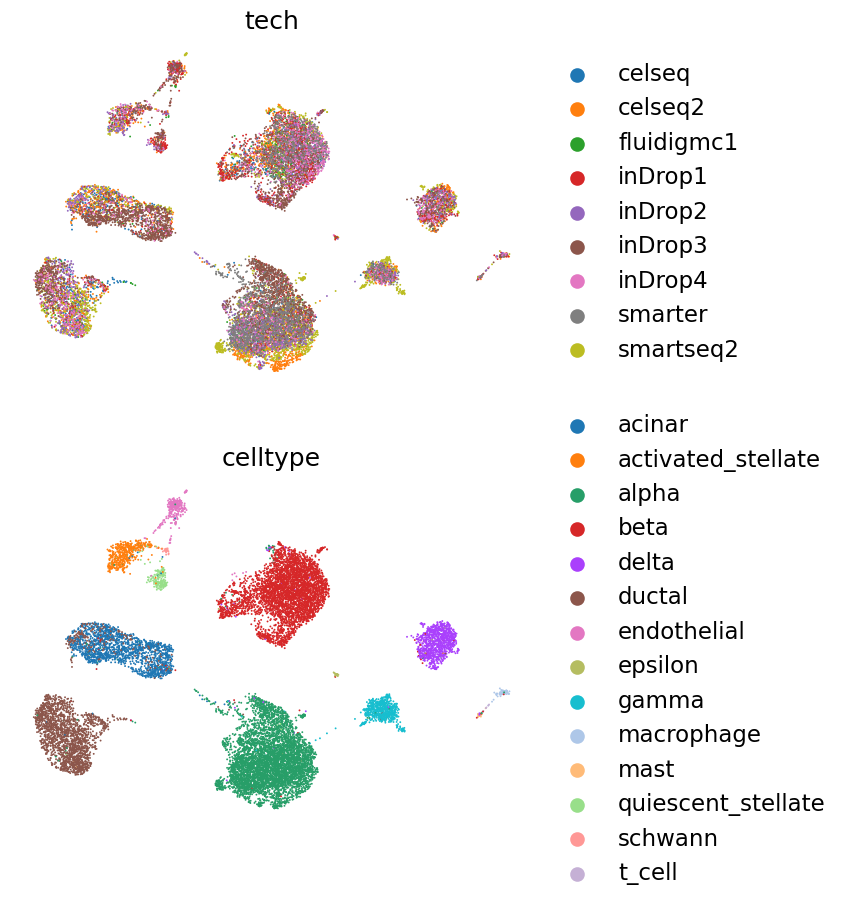

In [7]:
pca_embeddings = pd.read_csv('/path/Pancrease_seurat.csv', index_col=0)
adata.obsm['X_seurat'] = pca_embeddings.values
sc.pp.neighbors(adata, use_rep="X_seurat")
sc.tl.umap(adata, min_dist=0.5)
sc.pl.umap(adata, color=["tech", "celltype"], frameon=False, ncols=1)